<a href="https://colab.research.google.com/github/Alfredo2212/MIT-Applied-Data-Science/blob/main/Alfredo_RecommendationSystem_ElectiveProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [1]:
!pip install numpy==1.24.3
!pip install scikit-surprise==1.1.3

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-linux_x86_64.whl size=3311574 sha256=1dfbc93ec92ecce412d4fcb7f1a1409b6bd6e56601915e998e0062075320b532
  Stored in directory: /root/.cache/pip/wheels/f4/2b/26/e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [111]:
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv')

In [4]:
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
1,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
2,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
3,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09
4,A1QGNMC6O1VW39,0511189877,5.0,1.397434e+09


In [112]:
# Renaming columns to fit prepared codes below (user_id, prod_id, rating, timestamp)
column_name = ['user_id','prod_id','rating','timestamp']
for i,col in enumerate(column_name):
  df.rename(columns={df.columns[i]: col}, inplace=True)
df.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
1,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
2,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
3,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09
4,A1QGNMC6O1VW39,0511189877,5.0,1.397434e+09


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [113]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [114]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [115]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [116]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [93]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating,timestamp
1309,A3LDPF5FMB782Z,1400501466,5.0,1.336003e+09
1321,A1A5KUIIIHFF4U,1400501466,1.0,1.332547e+09
1334,A2XIOXRRYX0KZY,1400501466,3.0,1.371686e+09
1450,AW3LX47IHPFRL,1400501466,5.0,1.339805e+09
1455,A1E3OB6QMBKRYZ,1400501466,1.0,1.350086e+09


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [117]:
# Check the number of rows and columns and provide observations
df_final.shape

(60387, 4)

**Write your observations here:Rows left 60387 and Columns 4 **

### **Data types**

In [12]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60387 entries, 1309 to 7721198
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    60387 non-null  object 
 1   prod_id    60387 non-null  object 
 2   rating     60387 non-null  float64
 3   timestamp  60387 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.3+ MB


**Write your observations here:
user_id and prod_id are objects,
it is expected for user_id since user_id is a mixed string
while prod_id also object means it is possibly also a mixed integer
rating and timestamp are expected to be floating point.
**

### **Checking for missing values**

In [13]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60387 entries, 1309 to 7721198
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    60387 non-null  object 
 1   prod_id    60387 non-null  object 
 2   rating     60387 non-null  float64
 3   timestamp  60387 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.3+ MB


**Write your observations here:there is no missing value for all rows and columns**

### **Summary Statistics**

In [14]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

,rating
count,60387.000000
mean,4.289980
std,0.994979
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:
Rating have mean of 4.289 while the median is at 5 showing left skewed rating distribution with data concentrated on the right hand side
Should visualize this using boxplot to capture the outliers outside lower whisker and identify why it is rated that way to further improve rating
**

### **Checking the rating distribution**

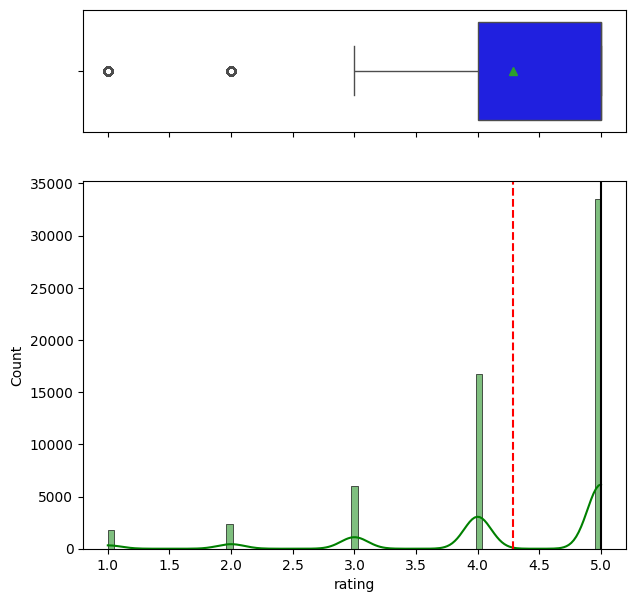

In [15]:
# Create the bar plot and provide observations
def histbox(data, feature, figsize=(7,7), kde=True, bins= None):
  f2, (axbox2,axhist2)= plt.subplots(
      2,
      sharex=True,
      gridspec_kw={"height_ratios":(0.25,0.75)},
      figsize=figsize,
  )

  sns.boxplot(data=data, x=feature, ax=axbox2, showmeans=True, color="blue")

  if bins == None:
    sns.histplot(data=data, x=feature, kde=kde, ax=axhist2, color='green')
  else:
    sns.histplot(data=data, x=feature, kde=kde, ax=axhist2, bins=bins, color='green')
  axhist2.axvline(data[feature].mean(), color="red", linestyle="--")
  axhist2.axvline(data[feature].median(), color="black", linestyle="-")


histbox(df_final, 'rating')


**Write your observations here:
It is expected from the summary statistics that low ratings are an outlier, boxplot shows that below rating 3 is considered an outlier. While the histogram pictures the skewness and data concentration concisely.
**

### **Checking the number of unique users and items in the dataset**

In [16]:
# Number of total rows in the data and number of unique user id and product id in the data
print(f"There are {df_final['user_id'].nunique()} unique users and {df_final['prod_id'].nunique()} unique items")

There are 1467 unique users and 5310 unique items


**Write your observations here:Unique user total is 1467 which is ~1% of total rows, this is expected after 50 ratings filtering for user. Also 5310 unique items after filtering with minimum of 5 ratings for each item**

### **Users with the most number of ratings**

In [17]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)

,rating
user_id,
ADLVFFE4VBT8,274
A3OXHLG6DIBRW8,218
A1ODOGXEYECQQ8,198
A36K2N527TXXJN,188
A680RUE1FDO8B,186
A25C2M3QF9G7OQ,175
A3LGT6UZL99IW1,170
AWPODHOB4GFWL,169
AGVWTYW0ULXHT,168


**Write your observations here:These are user with the highest amount of contribution for rating product, with as much as 520 rating per user and it is also accompanied by 5 other users until it hits 351 rating which is ~ 75%. Identifying these 5 users behavior can help understand in the reason of why an individual rate amazon product**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
# Calculate the average rating for each product
prod_rating_avg = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
prod_rating_count = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
prod_rating_df = pd.DataFrame({
    'rating_average':prod_rating_avg,
    'rating_count':prod_rating_count
})
# Sort the dataframe by average of ratings in the descending order
final_rating = prod_rating_df.sort_values('rating_average', ascending=False)
# See the first five records of the "final_rating" dataset
final_rating.head()

,rating_average,rating_count
prod_id,,
B00GTLN1BO,5.0,9
B007SZ0EHE,5.0,8
B0013LQD7Y,5.0,5
B007Z419BI,5.0,5
B0012Y6HC8,5.0,15


In [19]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_movies_with_min_interaction(data, n, min_interaction=100):

# Finding products with minimum number of interactions
  recommendations = data[data['rating_count']> min_interaction]

# Sorting values with respect to average rating
  recommendations = recommendations.sort_values(by = 'rating_average', ascending = False)

  return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [20]:
list(top_movies_with_min_interaction(final_rating, 5, 50))

['B0019EHU8G', 'B001TH7GUU', 'B003ES5ZUU', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [21]:
list(top_movies_with_min_interaction(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002V88HFE', 'B007WTAJTO', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [29]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

# Import defaultdict
from collections import defaultdict

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [30]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [173]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Loading the rating dataset
df_reader = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(df_reader, test_size= 0.2, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [143]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0060
Precision:  0.856
Recall:  0.872
F_1 score:  0.864


**Write your observations here:Model has precision of 85.6%, recall of 71.6% and F_1 score of 87.2%
This implies that through trainset, model successfully recommend  correct product 85.6% out of the time and able to identify relevant product 87.2% out of the time
**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [144]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z','1400501466', r_ui= 5, verbose = True )

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:
user 'A3LDPF5FMB782Z' with product '1400501466' has an estimated rating of 3.00. The truth is this combination of user & product has rating of 5.0. Utilize 5 neighbours and successfully done the required connection to predict an estimate.
**

Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [145]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [146]:
# Find unique user_id where prod_id is not equal to "1400501466"
non_A2UOHALGF2X77Q_users = n_users_not_interacted_with(df_final.shape[0], df_final, '1400501466') # ensures n = all rows to get all user_ids

# Print 5 head of n_users_not_interacted_with for project completion requirement
n_users_not_interacted_with(5, df_final, '1400501466')

['A12EVK82QUTSA6',
 'A303SNZ4AR7TDQ',
 'A28LUOEY0ECT9G',
 'A1IU7S4HCK1XK0',
 'A3QNX5KWHDV0GD']

In [147]:
# Check if "A2UOHALGF2X77Q" is in the n_users_not_interacted_with list
print(any(user == "A2UOHALGF2X77Q" for user in non_A2UOHALGF2X77Q_users))

True


* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [148]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A2UOHALGF2X77Q" ,'1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.003067513526501, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:
**Write your observations here:
user "A2UOHALGF2X77Q" ,'1400501466' doesn't have any interaction before, estimated rating of 4.00. Utilize 2 neighbours and successfully done the required connection to predict an estimate.
**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [149]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [40,50],
              'min_k': [6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs= -1)

# Fitting the data
gs.fit(df_reader)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9773616351718987
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [150]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name':'cosine',
              'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 50, min_k = 6, random_state = 1, verbose = False )
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9527
Precision:  0.848
Recall:  0.907
F_1 score:  0.877


**Write your observations here:User-user colaborative model has an improved overall with grid search fine tuning.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [151]:
# Get the mean actual rating for userId "A3LDPF5FMB782Z" and productId 1400501466
A3LDPF5FMB782Z_1400501466 = df_final[(df_final['user_id']=='A3LDPF5FMB782Z') & (df_final['prod_id']=='1400501466')].groupby(['user_id','prod_id'])['rating'].mean().reset_index()

# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=A3LDPF5FMB782Z_1400501466.loc[0,'rating'], verbose=True )

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.286012958247945, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [152]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_user_user_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose=True )

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.286012958247945, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:
Both prediction give the same estimated ratings value for different user, since it is unable to find user_user similarity from its neighbors. The model falls into its constant assumption without additional information from other users. Estimated rating for new user 4.29 which is the same as estimated rating for user that rated 5.00 in this case.
**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [153]:
# 0 is the inner id of the above user
neighbors = sim_user_user_optimized.get_neighbors(0, k = 5)

# Get neighbours user ID
neighbors_user_id = [trainset.to_raw_uid(inner_id) for inner_id in neighbors]
print(dict(zip(neighbors, neighbors_user_id)))

{3: 'A2V7EO331SFUF6', 6: 'A4U27URFECK1U', 7: 'A3284KYDZ00BZA', 9: 'A1DSRM2P0WGQNS', 11: 'A357B3PUHSVQA'}


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [136]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [154]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_user_optimized)

In [155]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B00020S7XK,5
2,B001TH7GUU,5
3,B001UI2FPE,5
4,B002BH3Z8E,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [157]:
# Declaring the similarity options
sim_options = {'name':'cosine',
               'user_bsed': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0060
Precision:  0.856
Recall:  0.872
F_1 score:  0.864


**Write your observations here:
Item item similarity have same metrics result to User user similarity
**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [158]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3LDPF5FMB782Z','1400501466', r_ui=A3LDPF5FMB782Z_1400501466.loc[0, 'rating'], verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=3.0, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:
Estimated rating given by this user-product interaction is 3.00 which is far off considering the max ratings are 5.00.
**

Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [159]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A2UOHALGF2X77Q','1400501466', verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.003067513526501, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here:
User A2UOHALGF2X77Q have an estimate of 4.00 rating for this particular product by utilizing two neighbours.
**

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [161]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k':[10,20,30],
    'min_k':[3,6,9],
    'sim_options':{'name':['msd','cosine'],
                   'user_based':[True,False]}
}
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs= -1)
# Fitting the data
gs.fit(df_reader)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9795260668878796
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [162]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options={
    'name':'cosine',
    'user_based': True
}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9530
Precision:  0.848
Recall:  0.907
F_1 score:  0.877


**Write your observations here:
Tuning item item similarity model resulted in performance increase.
**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [163]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=A3LDPF5FMB782Z_1400501466.loc[0, 'rating'], verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.286012958247945, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [164]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.286012958247945, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:
Both prediction give the same estimated ratings value for different user, since it is unable to find item_item similarity from neighbors.
**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [167]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final,'A1A5KUIIIHFF4U', 5,sim_item_item_optimized)

In [168]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id','predicted_ratings'])

,prod_id,predicted_ratings
0,B000BQ7GW8,5.0000
1,B001TH7GUU,5.0000
2,B00316263Y,5.0000
3,B004C9P9TM,5.0000
4,B007WTAJTO,4.9375


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [169]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8950
Precision:  0.85
Recall:  0.889
F_1 score:  0.869


**Write your observations here:
SVD model has the lowest RMSE but the classification accuracy is not greater than collaborative filtering
precision_recall_at_k() function with threshold of 3.5 probably didn't classify ratings proportionally.
**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [170]:
# Making prediction
svd.predict('A3LDPF5FMB782Z','1400501466', r_ui=A3LDPF5FMB782Z_1400501466.loc[0,'rating'], verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.84   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=3.838440398268666, details={'was_impossible': False})

**Write your observations here:
Prediction utilizing SVD gives more precise result, since SVD utilizes the whole matrix while similarity-based methods only use known neighbors. Estimated rating was 3.84 (.2f) with actual rating of 5.00, it is much accurate than collaborative filterings approach.
**

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [171]:
# Making prediction
svd.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 3.64   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=3.643523851583906, details={'was_impossible': False})

**Write your observations here:
for A2UOHALGF2X77Q - 1400501466 interaction the estimated rating was
3.64 (.2f)
**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [174]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10,20,30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2,0.4,0.6]
}
# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], n_jobs=-1)

# Fitting data
gs.fit(df_reader)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.900567605545089
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [177]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)
# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8843
Precision:  0.855
Recall:  0.89
F_1 score:  0.872


**Write your observations here:
Finding best parameter improves base svd model performance
**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [179]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=A3LDPF5FMB782Z_1400501466.loc[0, 'rating'], verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.06   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.058703570960271, details={'was_impossible': False})

In [180]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 3.81   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=3.8119817012831154, details={'was_impossible': False})

### **Conclusion and Recommendations**

In [ ]:
# Metrics comparison across all model
model = []
comparison_df = pd.DataFrame{

}

**Write your conclusion and recommendations here**